## FER2013 데이터 분석하기
> FER+ 데이터셋을 먼저 시도하였으나, 라벨에 노이즈가 많아 FER 데이터셋으로 전환합니다. (Revision 2024.10.02)

FER2013(Facial Expression Recognition 2013) 데이터셋은 사실 torchvision에서 이미 데이터 프리셋을 제공하는 데이터셋이지만<br>
csv로 구성된 이미지 데이터셋을 직접 핸들링하고, 분석해보면 재밌을 것 같아서 데이터를 별도로 다운 받아 사용해보겠습니다.

kaggle에서 fer 데이터를 다운 받아 압축을 해제합니다. (※ 실행 전 Kaggle API를 먼저 등록해주세요!)<br>
불필요한 파일은 압축 해제를 완료한 후 제거합니다.

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!mkdir data
!tar -xvzf fer2013.tar.gz -C data/
!rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip example_submission.csv fer2013.tar.gz icml_face_data.csv test.csv train.csv

필요한 라이브러리를 불러옵니다.

In [2]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from collections import Counter
from IPython.display import display

pandas로 fer 데이터(fer2013.csv)을 불러와 확인합니다.

In [3]:
df = pd.read_csv('data/fer2013/fer2013.csv')

display(df.head(), df.info(), Counter(df['Usage'])) # pandas의 테이블 시각화를 여러개 띄우고 싶을 땐 display 함수를 사용

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


None

Counter({'Training': 28709, 'PublicTest': 3589, 'PrivateTest': 3589})

fer 데이터는 총 35887개 행에, 라벨인 emotion 컬럼과 48*48 이미지를 숫자화한 pixels 컬럼, 각 이미지의 용도를 구분하는 Usage 컬럼이 있는 것으로 확인됐습니다.<br><br>
먼저 emotion의 클래스를 살펴보겠습니다.

0. Angry(화남)
1. Disgust(역겨움)
2. Fear(두려움)
3. Happy(행복함)
4. Sad(슬픔)
5. Surprise(놀람)
6. Neutral(중립)

Usage의 경우, 'Training'(28709개), 'PublicTest'(3589개), 'PrivateTest'(3589개)의 세 항목으로 분류되어 있는데,<br>
편의에 따라 Train: 'Training', Validation: 'PublicTest', Test: 'PrivateTest'로 분할하여 사용하겠습니다. (비율은 8:1:1 입니다.)

(fer+는 기존 라벨에 Contempt, unknown, NF 3개 항목을 추가하여 10개로 분류하는데 이미지와 매칭되지 않는 라벨, 중복, 누락 등이 있어 사용하지 않았습니다.)

---

데이터를 본격적으로 분리하기 전에 전체 항목에 대한 각 클래스 별 분포를 먼저 확인해보겠습니다.<br>
seaborn을 이용해 emotion 컬럼에 대한 barplot을 그려줍니다.

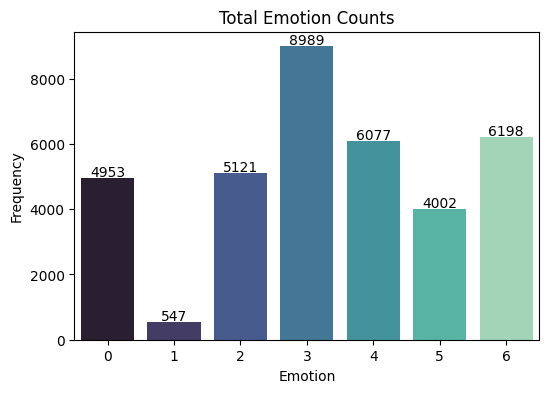

In [4]:
EMOTIONS={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def countEmotion(df):
    cnts = df['emotion'].value_counts().sort_index().reset_index()
    cnts.columns = ['emotion', 'count']
    #cnts['emotion'] = cnts['emotion'].map(EMOTIONS)

    return cnts

plt.figure(figsize=(6,4))

cnts = countEmotion(df)
bar_plot = sns.barplot(x='emotion', y='count', data=cnts, palette='mako')

for index, row in cnts.iterrows():
    bar_plot.text(x=index, y=row['count']+50, s=row['count'], ha='center')

plt.title("Total Emotion Counts")
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.show()

클래스 별 예시 데이터도 확인해보겠습니다.

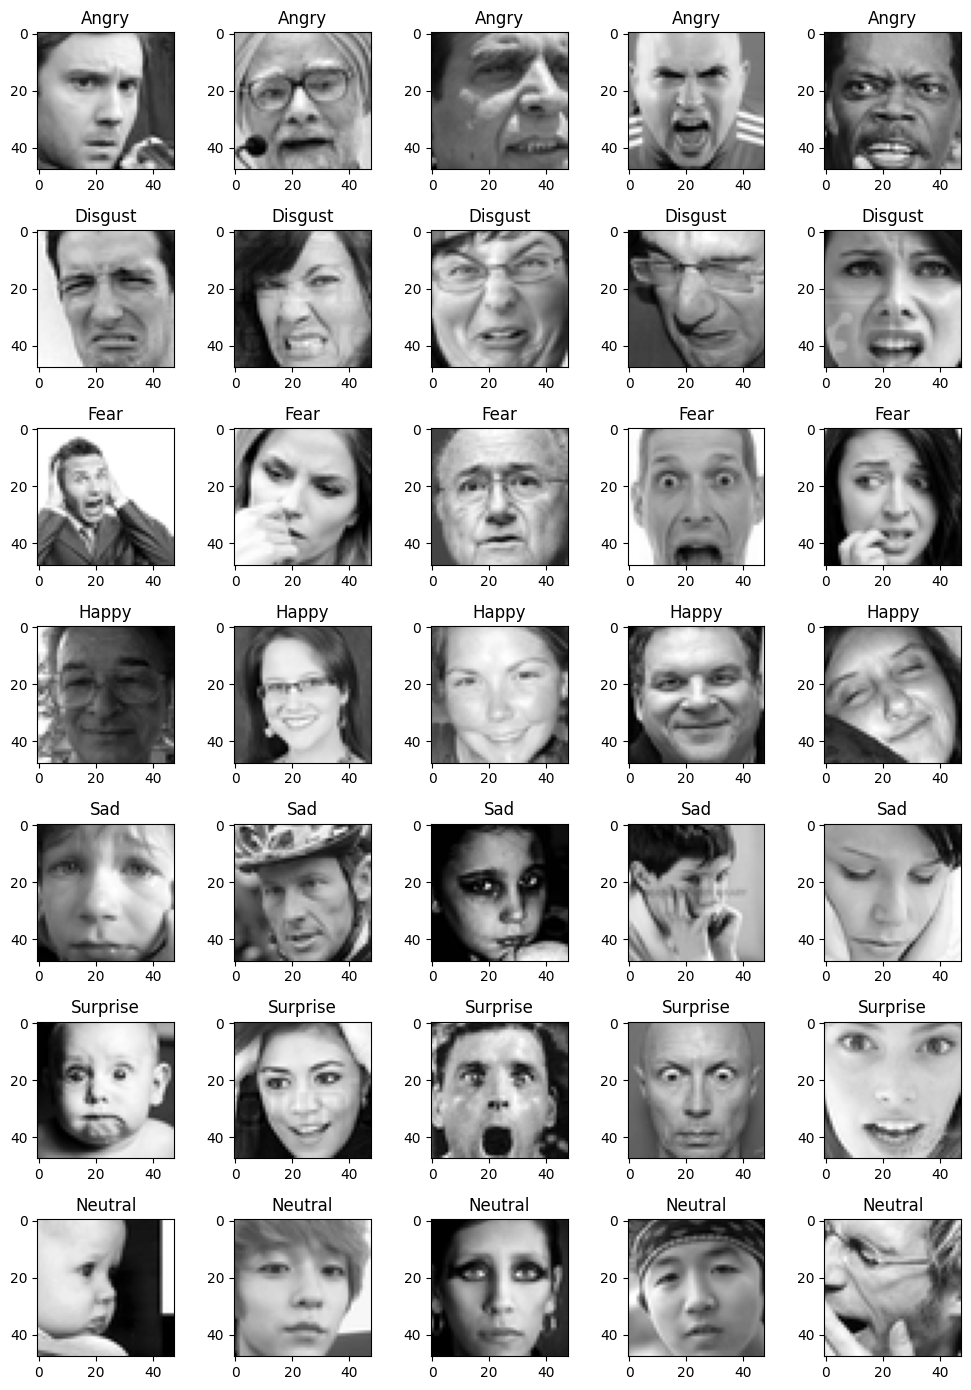

In [5]:
fig, axs = plt.subplots(7, 5, figsize=(10,14))

ex_group = df.groupby('emotion').nth[0:5].sort_values('emotion').reset_index()

for i in range(len(ex_group)):
    img = np.array(ex_group['pixels'][i].split(' '), dtype=np.uint8).reshape((48,48))
    axs[i//5][i%5].imshow(img, cmap='gray')
    axs[i//5][i%5].set_title(EMOTIONS[ex_group['emotion'][i]])
    test=1

plt.tight_layout()
plt.show()

클래스 별 데이터는 Neutral을 빼면 전반적으로 납득 가능하게 구성된 것 같습니다만 클래스 간의 데이터 불균형이 심한게 조금 우려됩니다.<br>
Disgust 클래스가 Happy 클래스 볼륨의 1/16 정도인데, 이대로 학습을 진행하게 되면 Disgust 클래스는 Underfitting이 발생할 것입니다.<br>
본격적인 학습에 들어가기 전에 데이터 증강이나 클래스 가중치를 적용하는 등의 보강법을 사용해야할 것 같습니다.

우선 Train, Validation, Test에서의 분포는 어떤지 살펴보겠습니다.

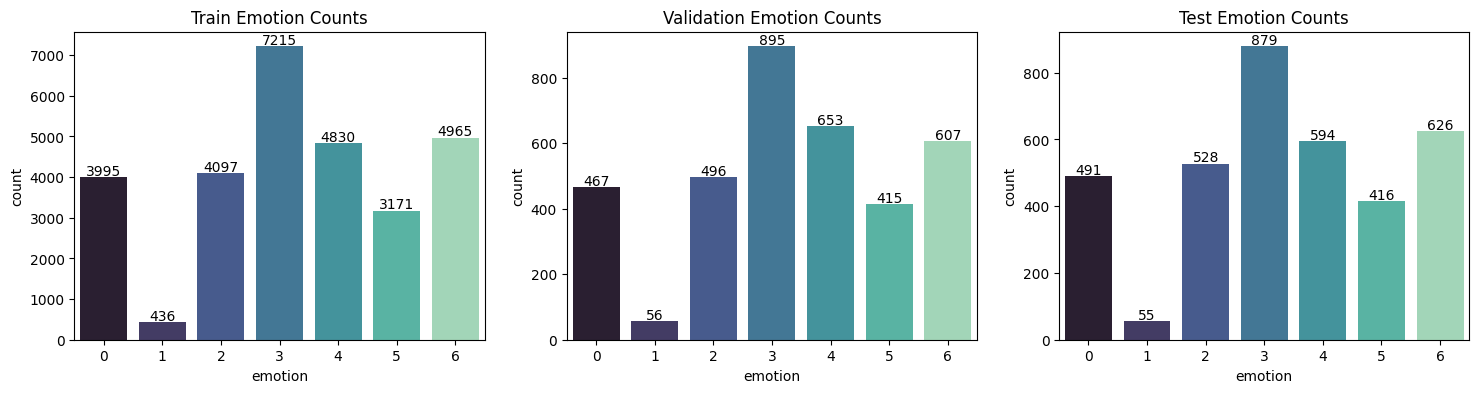

In [6]:
train_df = df[df['Usage']=='Training']
valid_df = df[df['Usage']=='PublicTest']
test_df = df[df['Usage']=='PrivateTest']

train_cnts = countEmotion(train_df)
valid_cnts = countEmotion(valid_df)
test_cnts = countEmotion(test_df)

fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

train_bar_plot = sns.barplot(x='emotion', y='count', data=train_cnts, palette='mako', ax=axs[0])
valid_bar_plot = sns.barplot(x='emotion', y='count', data=valid_cnts, palette='mako', ax=axs[1])
test_bar_plot = sns.barplot(x='emotion', y='count', data=test_cnts, palette='mako', ax=axs[2])

for index, row in train_cnts.iterrows():
    train_bar_plot.text(x=index, y=row['count']+50, s=row['count'], ha='center')

for index, row in valid_cnts.iterrows():
    valid_bar_plot.text(x=index, y=row['count']+5, s=row['count'], ha='center')

for index, row in test_cnts.iterrows():
    test_bar_plot.text(x=index, y=row['count']+5, s=row['count'], ha='center')

axs[0].set_title("Train Emotion Counts")
axs[1].set_title("Validation Emotion Counts")
axs[2].set_title("Test Emotion Counts")

plt.show()

다행히 적은 양의 Disgust 데이터이지만 각 데이터셋에 고르게 분배되어 있습니다.<br>
클래스 가중치 적용 학습을 먼저 시도해보고, 성능이 기대치 이하일 경우 샘플 가중치나 데이터 증강을 노려봐야겠습니다.


모델 학습을 위해 데이터셋을 구축하겠습니다.<br>
데이터셋은 Usage에서 분류한대로 Train, Test, Validation을 분할 저장하겠습니다.

In [22]:
train_dir = 'data/fer2013/train/'
valid_dir = 'data/fer2013/valid/'
test_dir = 'data/fer2013/test/'

for idx, data in df.iterrows():
    if data['Usage'] == 'Training':
        cls_train_dir = train_dir + f"{EMOTIONS[data['emotion']]}/"

        if not os.path.isdir(cls_train_dir):
            os.makedirs(cls_train_dir)
        
        img = np.array(data['pixels'].split(' '), dtype=np.uint8).reshape((48,48))
        img = Image.fromarray(img)

        save_path = cls_train_dir+f'fer_{idx:07d}.jpg'
        img.save(save_path)
    elif data['Usage'] == 'PublicTest':
        cls_valid_dir = valid_dir + f"{EMOTIONS[data['emotion']]}/"

        if not os.path.isdir(cls_valid_dir):
            os.makedirs(cls_valid_dir)
        
        img = np.array(data['pixels'].split(' '), dtype=np.uint8).reshape((48,48))
        img = Image.fromarray(img)

        save_path = cls_valid_dir+f'fer_{idx:07d}.jpg'
        img.save(save_path)
    else:
        cls_test_dir = test_dir + f"{EMOTIONS[data['emotion']]}/"

        if not os.path.isdir(cls_test_dir):
            os.makedirs(cls_test_dir)
        
        img = np.array(data['pixels'].split(' '), dtype=np.uint8).reshape((48,48))
        img = Image.fromarray(img)

        save_path = cls_test_dir+f'fer_{idx:07d}.jpg'
        img.save(save_path)


이것으로 모든 EDA 및 데이터셋 구축 작업을 마쳤습니다.
이제 모델을 구성하여 학습을 진행하도록 하겠습니다.